## **1. Import Dataset**

**Трохи для контексту (загальні відомості про датасет)**

Автомобільна компанія планує вийти на нові ринки зі своїми продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на поведінку існуючого ринку.

На існуючому ринку відділ продажів класифікував усіх клієнтів на 4 сегменти (A, B, C, D). Потім вони провели сегментовану інформаційно-пропагандистську роботу та комунікацію для різних сегментів клієнтів. Ця стратегія спрацювала для них надзвичайно добре. Вони планують використовувати цю ж стратегію на нових ринках, визначили потенційних клієнтів і хочуть автоматизувати процес сегментації. Таким чином завдання полягає у тому, щоби визначити найкращий класифікатор для поставленого завдання.

Дані:

**ID** Унікальний ID

**Gender** Гендер клієнта

**Ever_Married** Сімейний стан клієнта

**Age**	Вік клієнта

**Graduated** Чи випустився клієнт?

**Profession** Професія клієнта

**Work_Experience**	Досвід роботи у роках

**Spending_Score**	Оцінка рівня витрат клієнта

**Family_Size**	Кількість членів сім'ї клієнта (включаючи клієнта)

**Var_1** Анонімна категорія для клієнта

**Segmentation (target)** Customer Категорія клієнта відповідно до сегментації

In [126]:
#Завантажимо дані, виведемо назви колонок
df = pd.read_csv('customer-segmentation-classification.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [128]:
#Встановлюємо розмір нашого датасету
print('Розмір датасету : ', df.shape)

Розмір датасету :  (8068, 11)


Датасет складається з 8068 екземплярів та 11 атрибутів даних.

## **2. Data Preprocessing**

In [130]:
#Дослідимо наш датасет детальніше, переглянемо описову статистику для числових змінних
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [132]:
#Переглянемо описову статистику для категорій
df.describe(include=['O'])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


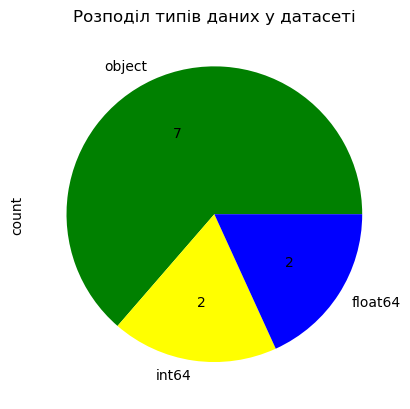

In [134]:
#Виведемо інформацію про типи даних у нашому датасеті у вигляді кругової діаграми
types_counts = df.dtypes.value_counts()
colors = ['#008000', '#FFFF00', '#0000FF']
plt.title('Розподіл типів даних у датасеті')
types_counts.plot.pie(autopct=lambda p: '{:.0f}'.format(p * sum(types_counts) / 100), colors=colors) 
plt.show()

In [136]:
#Перевіримо наявність дублікатів
duplicate_count = df.duplicated().sum()
print('Кількість дублікатів : ', duplicate_count)

Кількість дублікатів :  0


In [138]:
#Перейменуємо колонку Var_1 для кращого розуміння
df=df.rename(columns={"Var_1":"Category"})

In [140]:
#Виключимо колонку ID, бо вона не дуже потрібна у нашому дослідженні
df=df.drop(columns="ID")

In [142]:
#Розділимо колонки на числові та категоріальні
numeric_features = []
categorical_features = []

for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        numeric_features.append(column)
    elif df[column].dtype == 'object':
        categorical_features.append(column)

print("Numeric Features:", numeric_features)
print(140 * '-')
print("Categorical Features:", categorical_features)

Numeric Features: ['Age', 'Work_Experience', 'Family_Size']
--------------------------------------------------------------------------------------------------------------------------------------------
Categorical Features: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Category', 'Segmentation']


In [144]:
#Перевіряємо, чи існують пропуски у даних
print(df.isnull().sum())

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Category            76
Segmentation         0
dtype: int64


Отже, пропуски існують, проаналізуймо це детальніше (нижче)

In [147]:
#Перевіряємо, скільки пропуски становлять % у відношенні до даних
def count_missings(df):
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.concat([missing_values, missing_percentage], axis=1)
    missing_df.columns = ['Missing Count', 'Missing %']
    missing_df_sorted = missing_df[missing_df['Missing %'] > 0.01].sort_values(by='Missing %', ascending=False)
    
    return missing_df_sorted

In [96]:
count_missings(df)

,Missing Count,Missing %
Work_Experience,829,10.275161
Family_Size,335,4.152206
Ever_Married,140,1.735250
Profession,124,1.536936
Graduated,78,0.966782
Category,76,0.941993


З огляду на результати, можемо зробити висновок, що найбільша кількість даних відсутня у категорії **Work_Experience**, а також у категоріях **Family_Size** та **Ever_Marries**

Займемось заповненням пропусків або імпутацією. Для цього використаємо наступну стратегію:

1. Для категоріальних змінних використаємо найпоширеніше значення - моду.
2. Числові змінні візуалізуємо, якщо розподіл буде нормальним, то заповнимо середніми значеннями, якщо зі значним зміщеннями, то медіанним, щоб уникнути значної асиметрії

In [155]:
#Заповнюємо пропуски у категоріальних змінних
categorical_features = ['Ever_Married', 'Graduated', 'Profession', 'Category']

for feature in categorical_features:
    mode_value = df[feature].mode()[0]  # Отримуємо моду для кожної змінної
    df[feature].fillna(mode_value, inplace=True)  # Заповнюємо пропуски модою

In [157]:
#Перевіряємо, чи залишились пропуски у категоріальних змінних
print(df[categorical_features].isnull().sum())

Ever_Married    0
Graduated       0
Profession      0
Category        0
dtype: int64


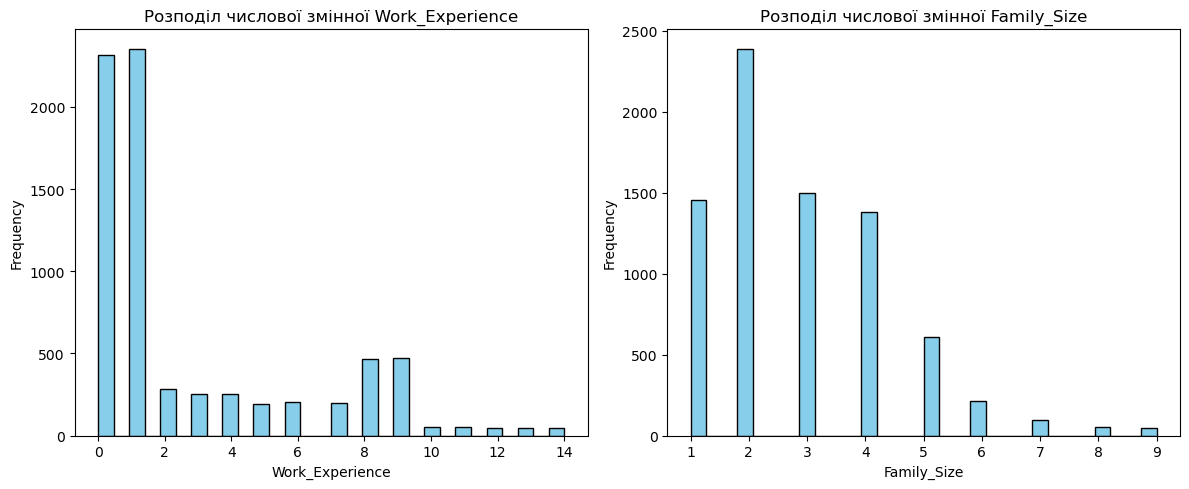

In [165]:
# Візуалізація розподілів числових ознак з пропусками
numeric_features_with_missing = ['Work_Experience', 'Family_Size']

plt.figure(figsize=(12, 5))
for i, feature in enumerate(numeric_features_with_missing, 1):
    plt.subplot(1, 2, i)
    df[feature].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Розподіл числової змінної {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Бачимо, що в обох випадках розподіли зміщенні вліво, тому пропуски краще заповнити медіанними значеннями.

In [168]:
# Заповнення пропусків у числових змінних
for feature in numeric_features_with_missing:
    median_value = df[feature].median()  # Обчислення медіанного значення
    df[feature].fillna(median_value, inplace=True)  # Заповнення пропусків медіанним значенням

In [172]:
#Перевіряємо пропуски після маніпуляцій
df.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Category           0
Segmentation       0
dtype: int64

Пропусків немає, отже, проблема успішно усунена

In [175]:
# Збереження оброблених даних у новий файл CSV
df.to_csv('processed_data.csv', index=False)

print("Дані успішно збережені у файл 'processed_data.csv'.")

Дані успішно збережені у файл 'processed_data.csv'.


In [181]:
#Розділимо колонки на числові та категоріальні
numeric_features = []
categorical_features = []

for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        numeric_features.append(column)
    elif df[column].dtype == 'object':
        categorical_features.append(column)

print("Numeric Features:", numeric_features)
print(140 * '-')
print("Categorical Features:", categorical_features)

Numeric Features: ['Age', 'Work_Experience', 'Family_Size']
--------------------------------------------------------------------------------------------------------------------------------------------
Categorical Features: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Category', 'Segmentation']


In [185]:
# Перевіримо дані на викиди (метод IQR)
outliers_info = {}
for column in numeric_features:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Границі викидів
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Знаходимо викиди
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers_info[column] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': len(outliers),
        'outliers_percentage': len(outliers) / len(df) * 100
    }

In [187]:
# Поглянемо на інформацію про викиди
outliers_info

{'Age': {'lower_bound': -4.5,
  'upper_bound': 87.5,
  'num_outliers': 71,
  'outliers_percentage': 0.8800198314328209},
 'Work_Experience': {'lower_bound': -6.0,
  'upper_bound': 10.0,
  'num_outliers': 189,
  'outliers_percentage': 2.342588001983143},
 'Family_Size': {'lower_bound': -1.0,
  'upper_bound': 7.0,
  'num_outliers': 94,
  'outliers_percentage': 1.1650966782350025}}

Загалом викиди становлять 1-2% у наших, однак такі класифікатори як SVM, kNN, AdaBoost можуть бути чутливими до таких значень, тому пропоную створити два варіанти даних і порівняти результати.

In [196]:
# Обробка викидів шляхом заміни їх на межі IQR для кожної числової колонки

# Створення копії набору даних для обробки викидів
data_capped = df.copy()

# Заміна викидів на межові значення IQR
for column in numeric_features:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Замінюємо викиди на відповідні граничні значення
    data_capped[column] = data_capped[column].clip(lower=lower_bound, upper=upper_bound)

# Відображення перших кількох рядків модифікованого набору даних
data_capped.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Category,Segmentation
0,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38.0,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40.0,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [261]:
# Збережемо оброблений файл з даними, де викиди були замінені на межі IQR
data_capped.to_csv('processed_data_final.csv', index=False)

print("Дані успішно збережені у файл 'processed_data_final.csv'.")

Дані успішно збережені у файл 'processed_data_final.csv'.


## **3. Data Vizualization**

### Target Value Exploration (Segmentation)

In [263]:
# Проаналізуємо статистичну інформацію
df['Segmentation'].describe()

count     8068
unique       4
top          D
freq      2268
Name: Segmentation, dtype: object

In [265]:
# Глянемо розподіл за класами
df['Segmentation'].value_counts()

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64

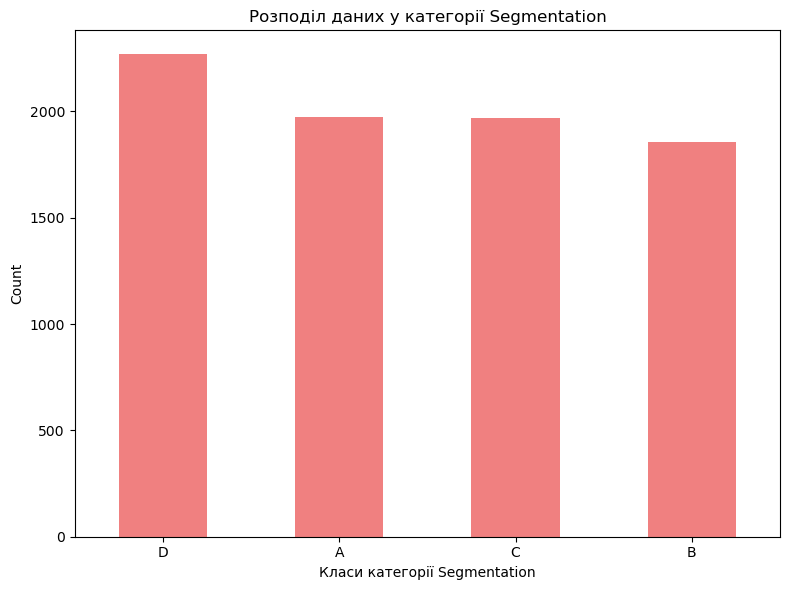

In [267]:
# Зобразимо стовпчикову діаграму для класів категорії Segmentation
plt.figure(figsize=(8, 6))
df['Segmentation'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Розподіл даних у категорії Segmentation')
plt.ylabel('Count')
plt.xlabel('Класи категорії Segmentation')
plt.xticks(rotation=0)
plt.tight_layout()

# Покажемо графік
plt.show()

Можемо зробити висновок про те, що датасет є доволі збалансованим.

<Figure size 2000x1500 with 0 Axes>

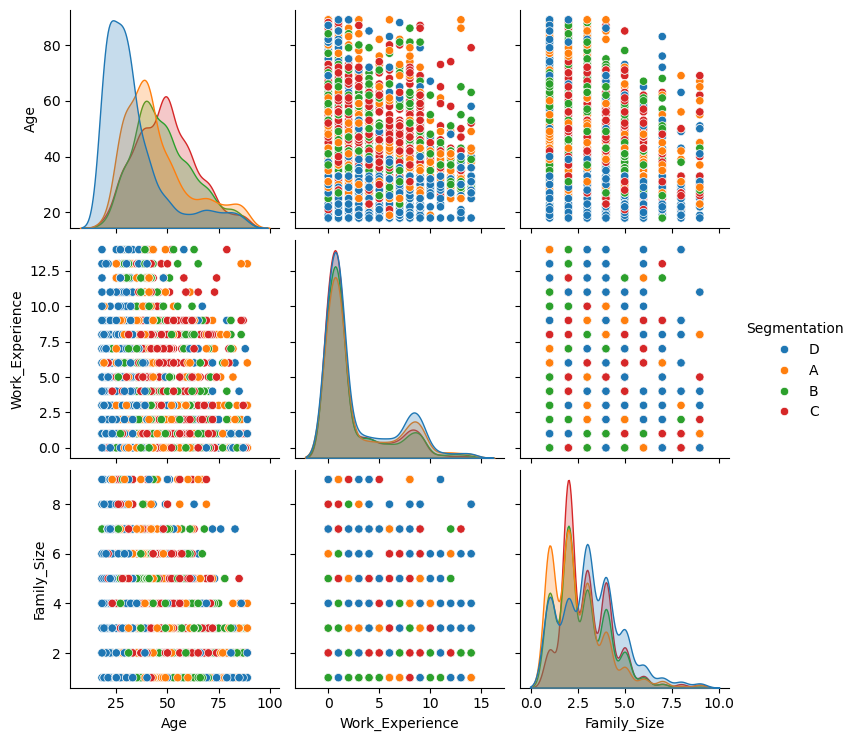

In [269]:
# Зобразимо pairplot для класів категорії Segmentation
plt.figure(figsize=(20,15))
sns.pairplot(df, hue='Segmentation')
plt.show()

На основі даних можемо зробити такі висновки:
1. Як правило, молодші люди та ті, хто має менше досвіду належать до категорії D
2. Категорії А і С мають схожі розподіли, що може вказувати на проблему з їх подальшою класифікацією.

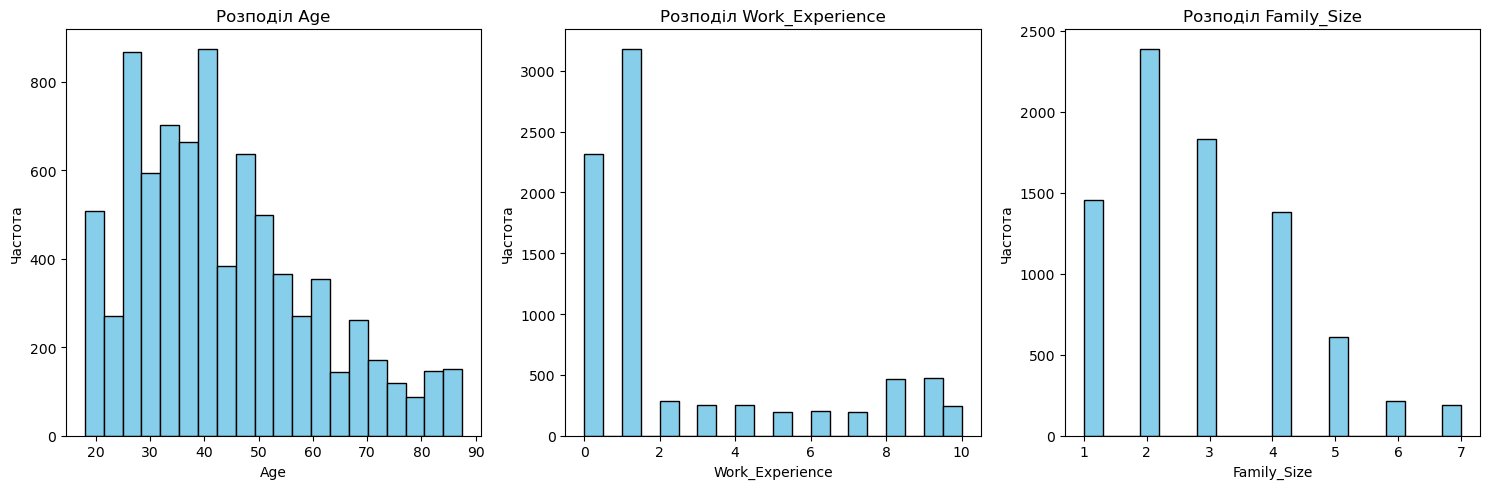

In [271]:
# Побудуємо гістограми для кожної з числових ознак
plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    plt.hist(data_capped[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Розподіл {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Загальні висновки:
1. Дані вказують на те, що вибірка орієнтована на молодих людей із невеликим досвідом роботи та маленькими сім'ями (які складаються здебільшого з подружжя без дітей).
2. Такі особливості розподілу можуть бути корисними при виборі ознак для класифікації та для інтерпретації результатів моделі.


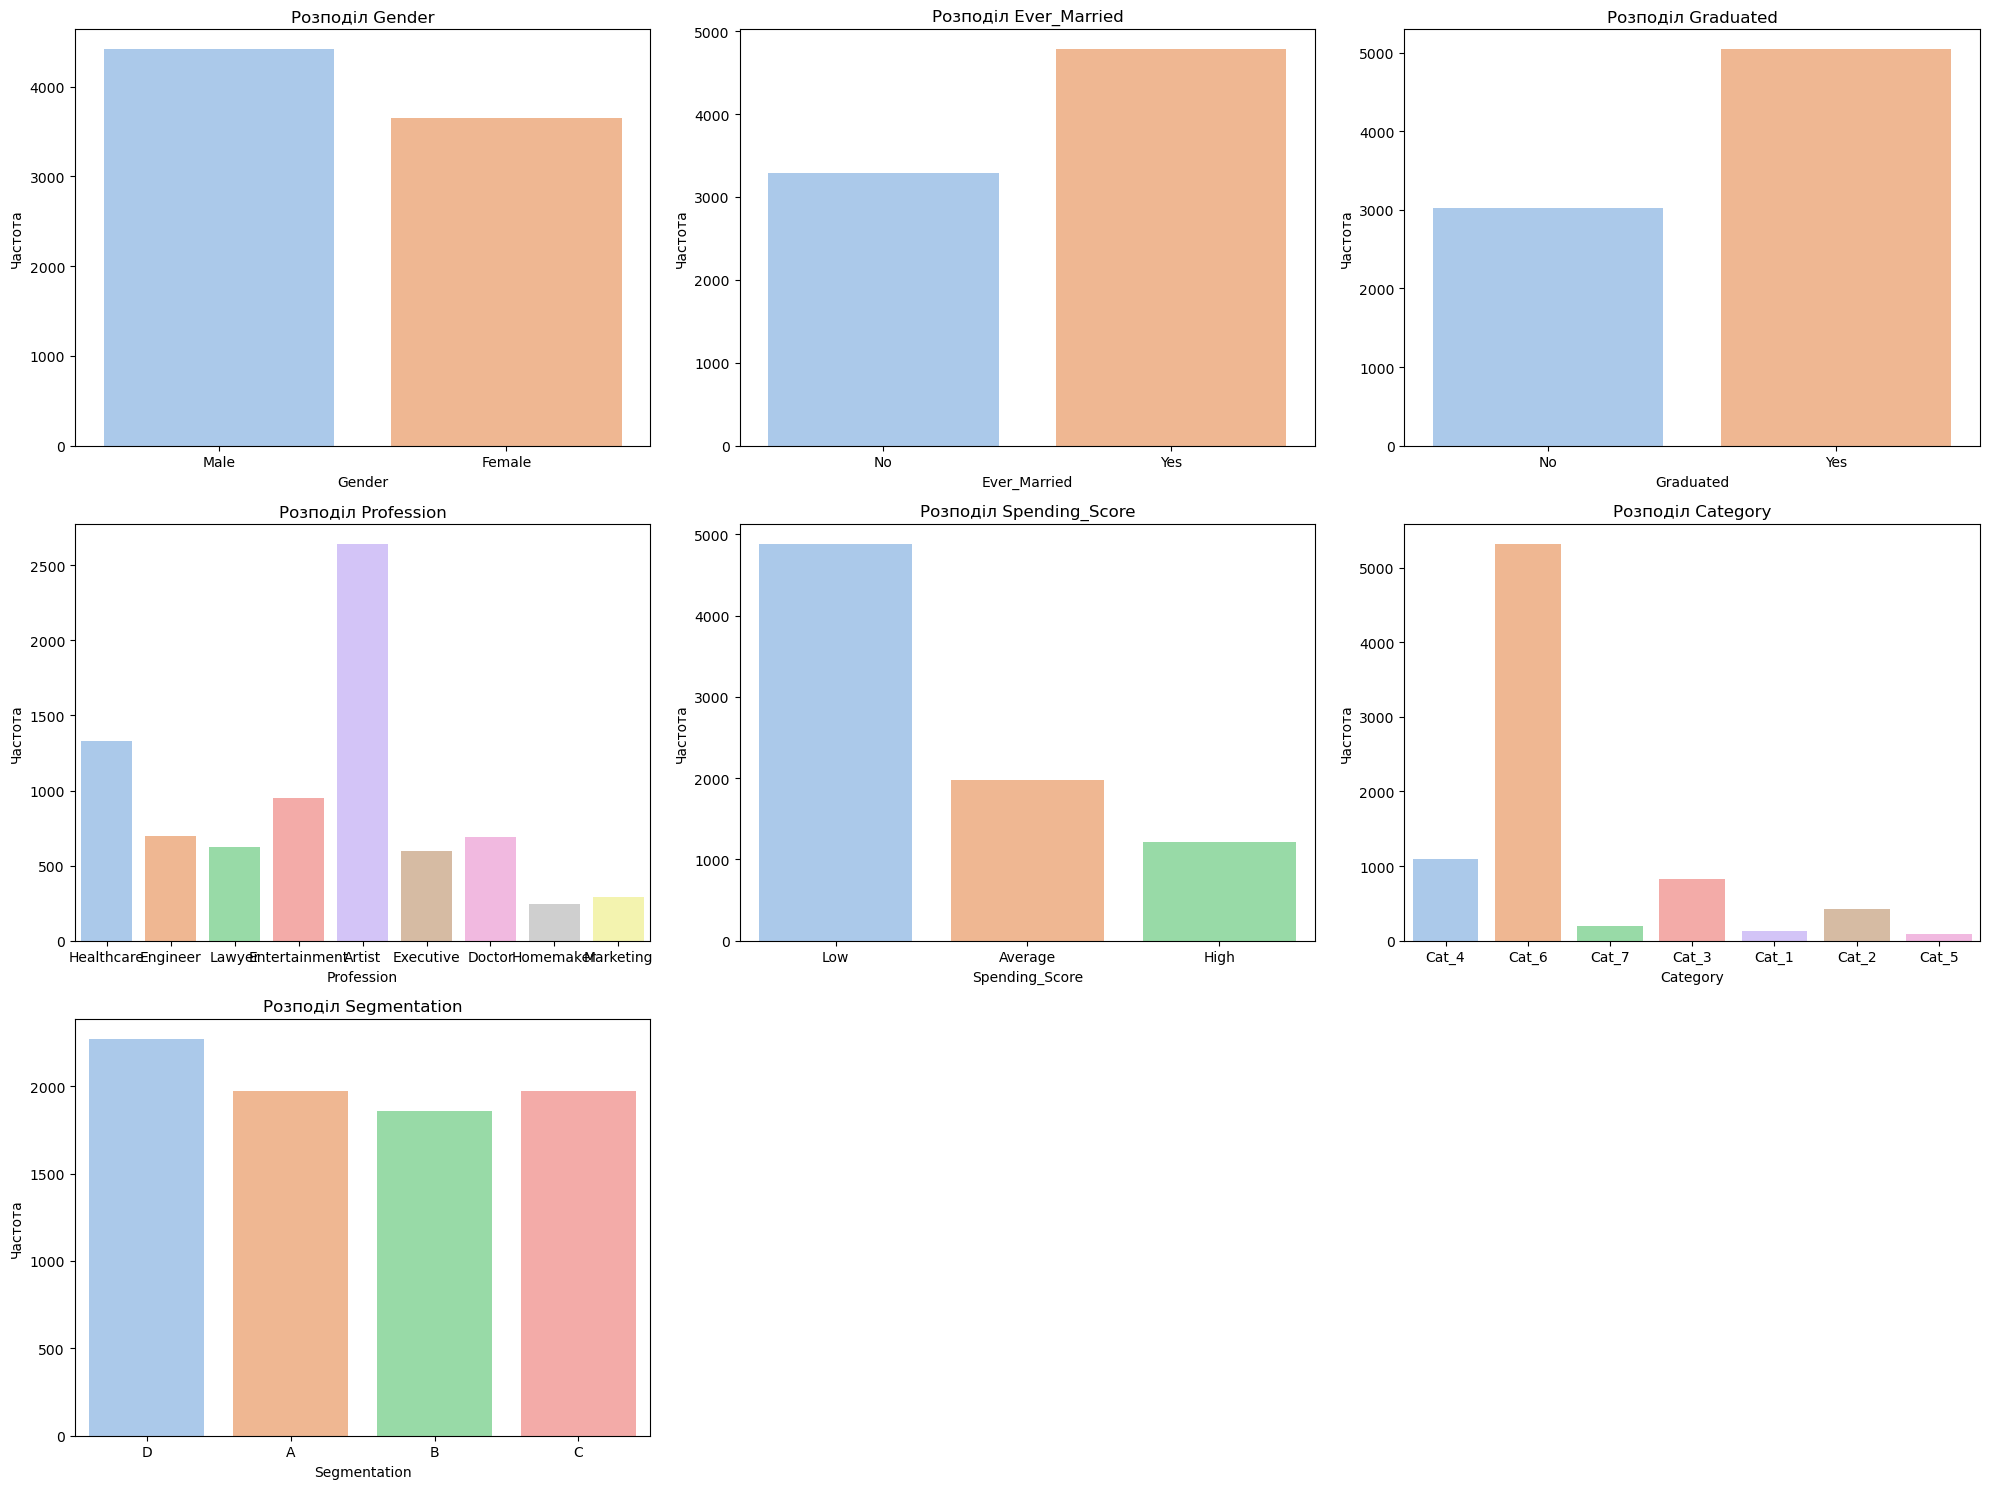

In [275]:
# Побудуємо countplot для кожної категоріальної ознаки
plt.figure(figsize=(20, 15))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)  
    sns.countplot(data=data_capped, x=column, palette='pastel')
    plt.title(f'Розподіл {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()


Основні інсайти:
1. Чоловіки переважають над жінками.
2. Більшість клієнтів автомобільної фірми одружені.
3. Значно більше людей з вищою освітою.
4. Найбільша кількість людей працює у сфері мистецтва, найменше — в маркетингу.
5. Найпоширеніша категорія — низькі витрати (люди мало витрачають).

### Categorical Data Encoding (Manual Mapping)

In [280]:
data_capped["Gender"].replace({"Male":[1],"Female":[0]},inplace=True)

In [282]:
data_capped["Ever_Married"].replace({"No":0,"Yes":1},inplace=True)

In [284]:
data_capped["Graduated"].replace({"No":0,"Yes":1},inplace=True)

In [286]:
data_capped["Profession"].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing'], dtype=object)

In [288]:
data_capped["Profession"].replace({"Healthcare":0,"Engineer":1,'Lawyer':2, 'Entertainment':3, 'Artist':4,
       'Executive':5, 'Doctor':6, 'Homemaker':7, 'Marketing':8},inplace=True)

In [290]:
data_capped["Spending_Score"].unique()

array(['Low', 'Average', 'High'], dtype=object)

In [290]:
data_capped["Spending_Score"].unique()

array(['Low', 'Average', 'High'], dtype=object)

In [292]:
data_capped["Spending_Score"].replace({"Low":0,"Average":1,"High":2},inplace=True)

In [294]:
data_capped["Category"].unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', 'Cat_5'],
      dtype=object)

In [296]:
data_capped["Category"].replace({'Cat_4':3, 'Cat_6':5, 'Cat_7':6, 'Cat_3':2, 'Cat_1':0, 'Cat_2':1, 'Cat_5':4},inplace=True)

In [298]:
data_capped["Segmentation"].unique()

array(['D', 'A', 'B', 'C'], dtype=object)

In [300]:
data_capped["Segmentation"].replace({"A":0,"B":1,"C":2,"D":3},inplace=True)

In [303]:
# Збережемо оброблений файл з категоріальними даними після обробки
data_capped.to_csv('processed_data_final_encoding.csv', index=False)

print("Дані успішно збережені у файл 'processed_data_final_encoding.csv'.")

Дані успішно збережені у файл 'processed_data_final_encoding.csv'.


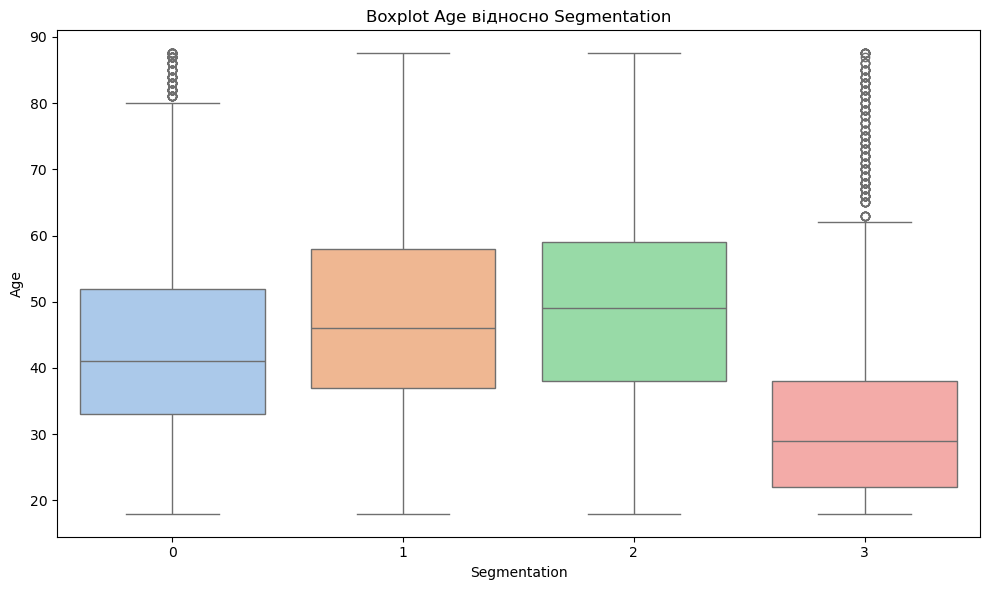

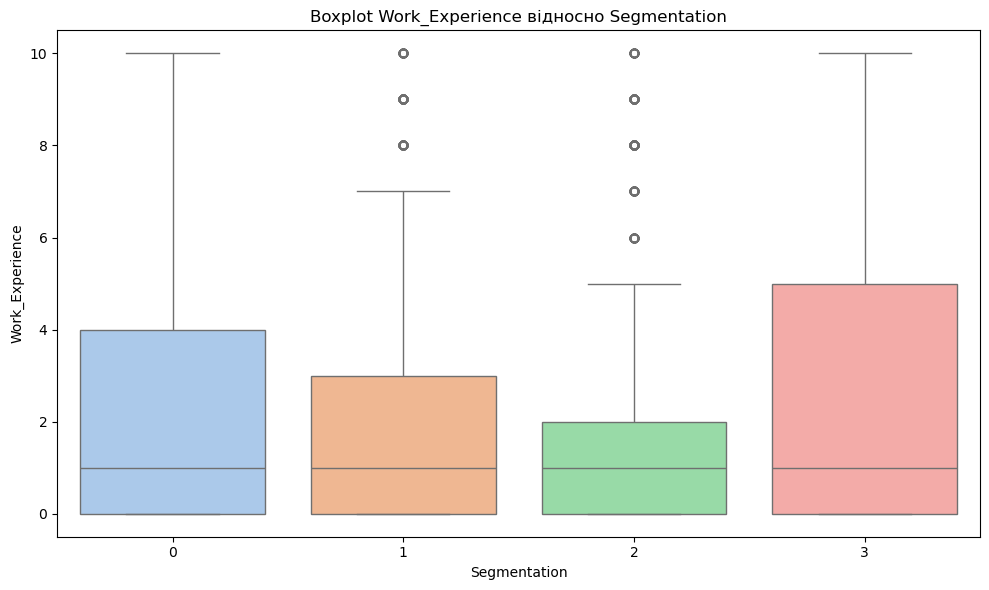

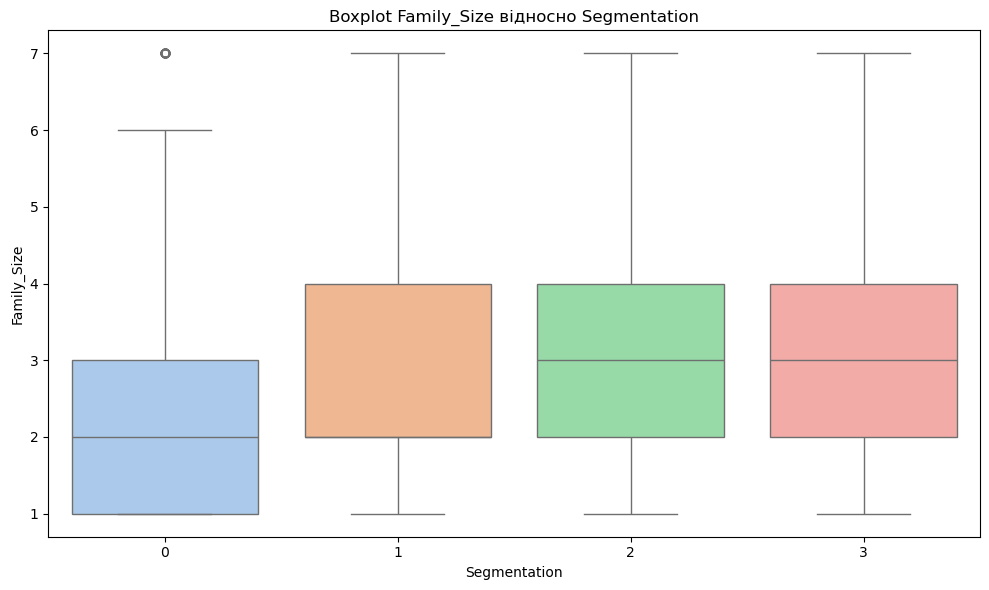

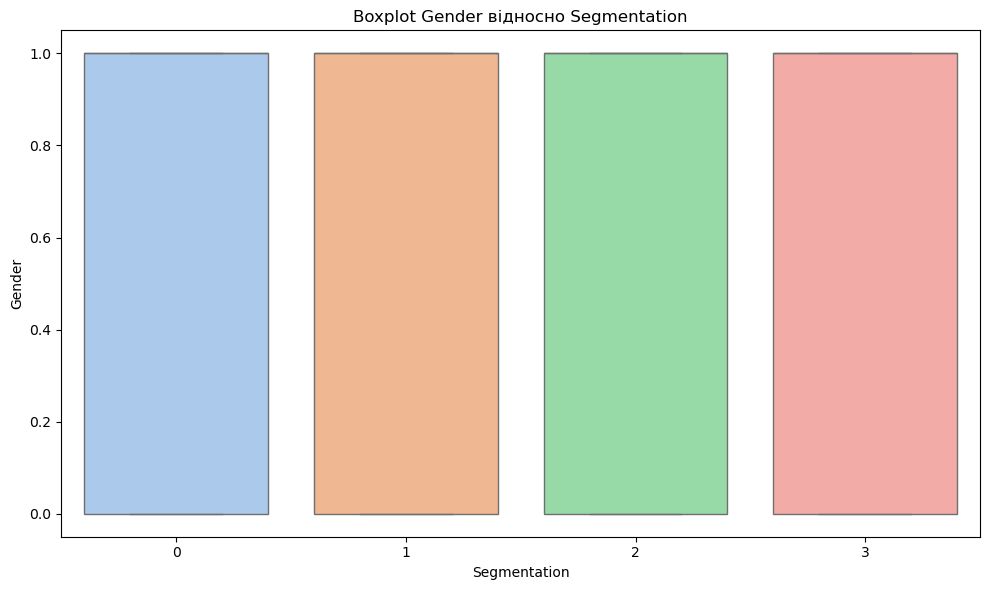

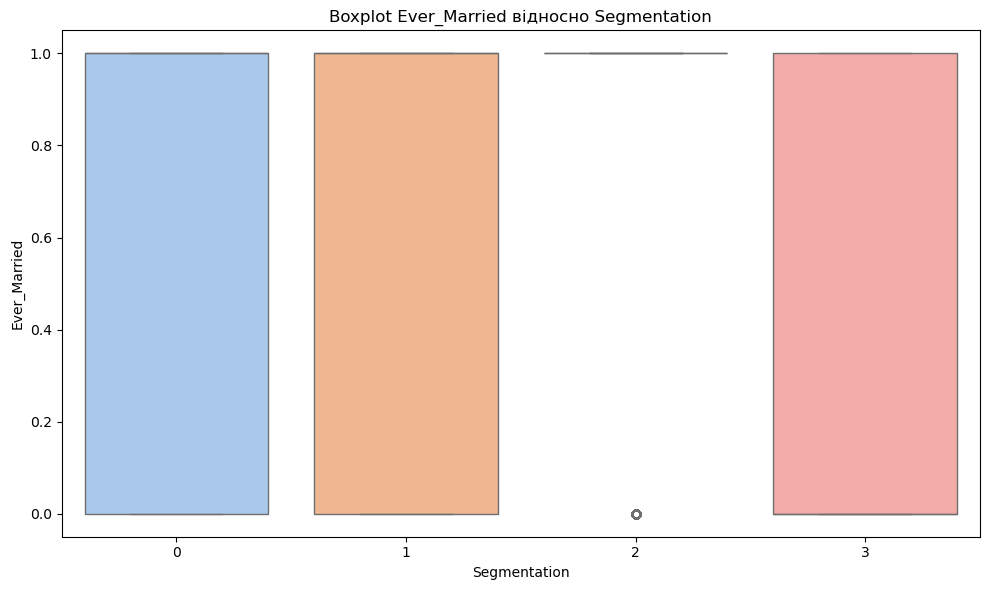

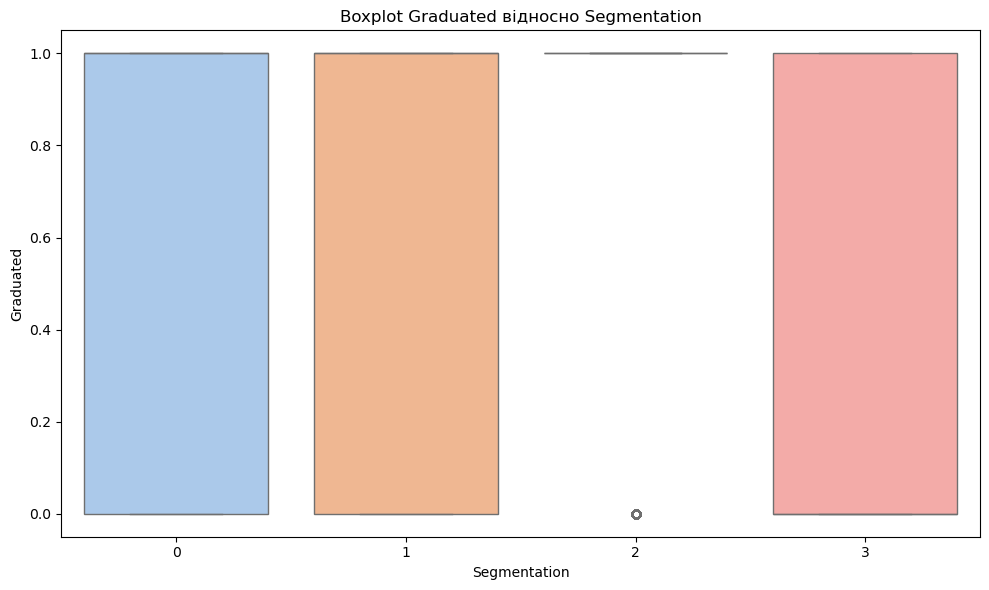

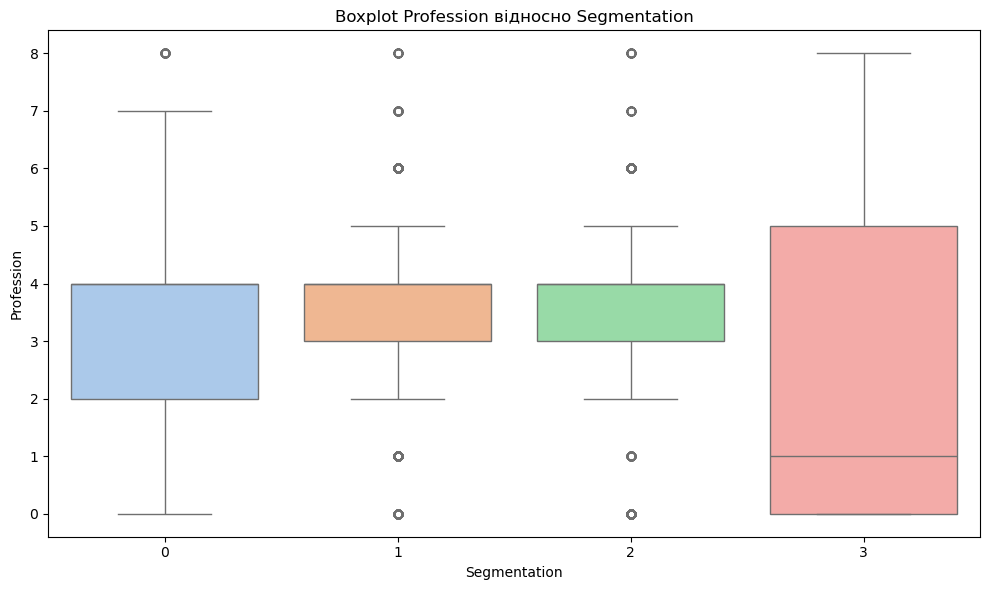

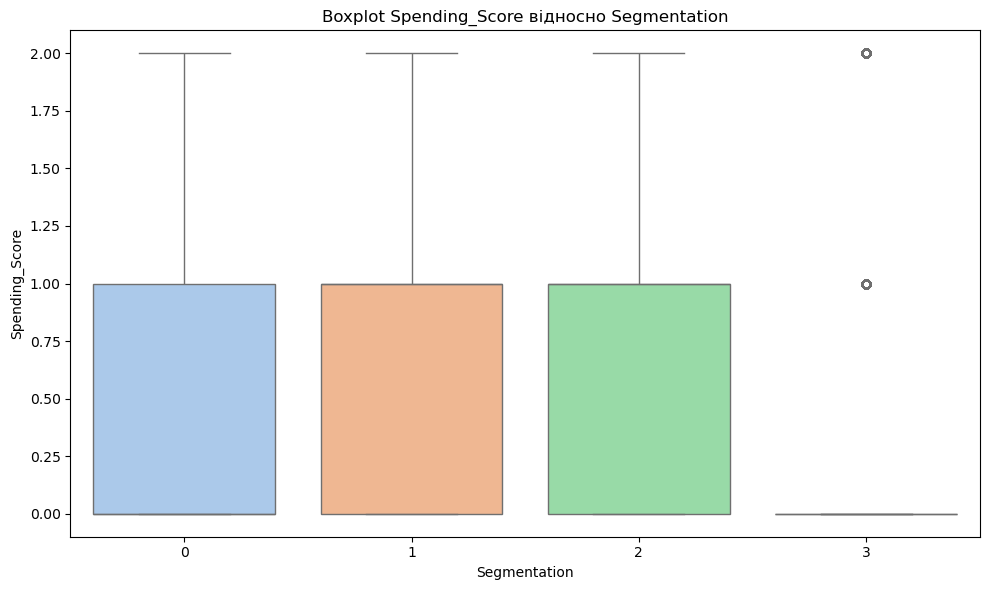

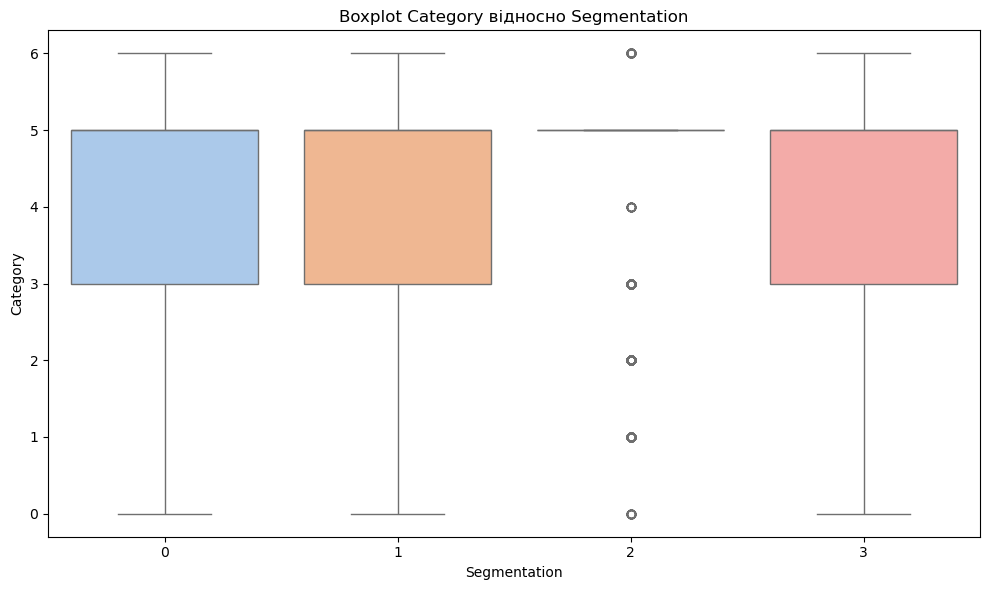

In [314]:
# Визначимо числові та категоріальні ознаки
numeric_features = ['Age', 'Work_Experience', 'Family_Size']
categorical_encoded_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Category']
all_features = numeric_features + categorical_encoded_features

# Побудуємо boxplot для кожної ознаки окремо, щоб уникнути перевантаження пам'яті
for column in all_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data_capped, x='Segmentation', y=column, palette='pastel')
    plt.title(f'Boxplot {column} відносно Segmentation')
    plt.xlabel('Segmentation')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

Отже, деякі ознаки, такі як Age і Work_Experience, показують різну варіативність та наявність викидів у різних сегментах.
Інші ознаки, як-от Gender та Graduated, не показують значних відмінностей між сегментами, що може вказувати на меншу інформативність цих змінних.

In [321]:
# Рахуємо кореляційну матрицю
correlation_matrix = data_capped.corr()

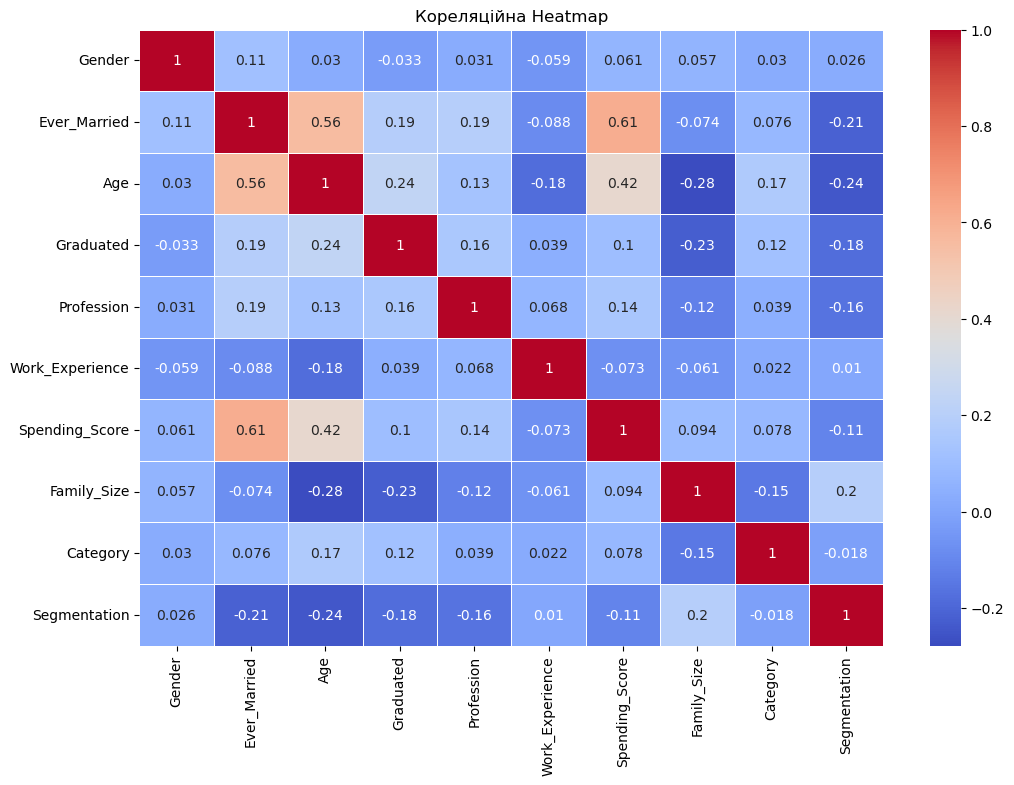

In [323]:
# Малюємо Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляційна Heatmap')
plt.show()

Декілька висновків:
1. Найбільш значущими для сегментації є такі змінні, як "Age", "Ever_Married", "Family_Size" та "Graduated".
2. Сильних кореляцій (>0.5 або <-0.5) немає, що свідчить про те, що жодна з ознак не є домінуючою у визначенні сегментації.
3. У матриці присутня значна кореляція ознак, проведемо аналіз мультиколінеарності

## **4. Data Scaling**

In [341]:
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = data_capped.drop('Segmentation', axis=1)
y = data_capped['Segmentation']

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Display the normalized data as a DataFrame for better understanding
normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
normalized_df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Category
0,0.909164,-1.206653,-1.285917,-1.29219,-1.531580,-0.456344,-0.736833,0.805152,-0.808370
1,-1.099912,0.828738,-0.327084,0.77388,-1.065866,-0.456344,0.612411,0.111509,-0.808370
2,-1.099912,0.828738,1.410800,0.77388,-1.065866,-0.456344,-0.736833,-1.275777,0.600711
3,0.909164,0.828738,1.410800,0.77388,-0.600152,-0.778742,1.961655,-0.582134,0.600711
4,-1.099912,0.828738,-0.207230,0.77388,-0.134438,-0.456344,1.961655,2.192437,0.600711
...,...,...,...,...,...,...,...,...,...
8063,0.909164,-1.206653,-1.285917,-1.29219,0.331276,-0.778742,-0.736833,2.886080,-2.921991
8064,0.909164,-1.206653,-0.506866,-1.29219,0.796989,0.188452,-0.736833,0.805152,-0.808370
8065,-1.099912,-1.206653,-0.626720,0.77388,-1.531580,-0.456344,-0.736833,-1.275777,0.600711
8066,-1.099912,-1.206653,-0.986282,0.77388,-1.531580,-0.456344,-0.736833,0.805152,0.600711


## **5. Predictive Modelling**

SVM, KNN: потребують масштабування (нормалізації), а також можуть бути чутливі до аномальних показників
Random Forest, Desicion Tree: не потребують
AdaBoost: можливий різний підхід

Почнемо з методів, що не потребують нормалізації

In [343]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree

In [351]:
X = normalized_df
y = data_capped['Segmentation'].values

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,stratify=y)

## Decision Tree

In [356]:
# Створюємо модель Decision Tree
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

# Навчаємо модель на тренувальних даних
dt_model.fit(X_train, y_train)

# Передбачаємо цільову змінну на тестових даних
y_pred = dt_model.predict(X_test)

# Виводимо результати
print("Decision Tree accuracy score : ", accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred)
print(report)

Decision Tree accuracy score :  0.4770755885997522
              precision    recall  f1-score   support

           0       0.36      0.47      0.41       394
           1       0.35      0.15      0.21       372
           2       0.52      0.54      0.53       394
           3       0.59      0.70      0.64       454

    accuracy                           0.48      1614
   macro avg       0.46      0.46      0.45      1614
weighted avg       0.46      0.48      0.46      1614



In [358]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

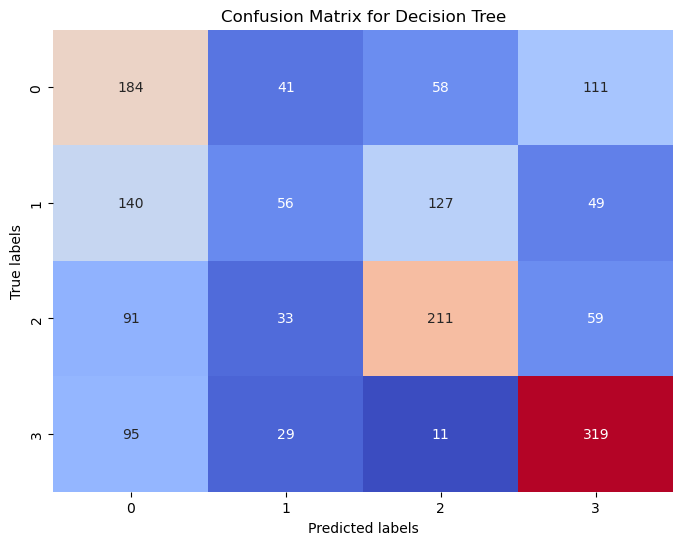

In [360]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for Decision Tree')

## Random Forest

In [362]:
rf = RandomForestClassifier(criterion='entropy', max_depth=5).fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [364]:
print("Random Forest accuracy score : ", accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred)
print(report)

Random Forest accuracy score :  0.5080545229244114
              precision    recall  f1-score   support

           0       0.40      0.55      0.46       394
           1       0.37      0.18      0.24       372
           2       0.54      0.54      0.54       394
           3       0.65      0.71      0.68       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



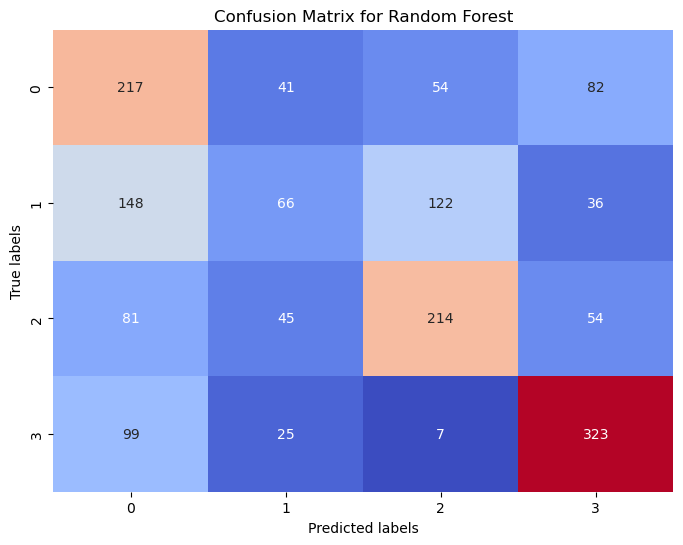

In [366]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for Random Forest')

## AdaBoost

In [368]:
AdaBoost = AdaBoostClassifier(n_estimators=100).fit(X_train,y_train)
y_pred=AdaBoost.predict(X_test)

In [370]:
print("AdaBoost accuracy score : ", accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred)
print(report)

AdaBoost accuracy score :  0.509913258983891
              precision    recall  f1-score   support

           0       0.41      0.50      0.45       394
           1       0.43      0.28      0.34       372
           2       0.49      0.52      0.50       394
           3       0.66      0.70      0.68       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.51      0.51      0.50      1614



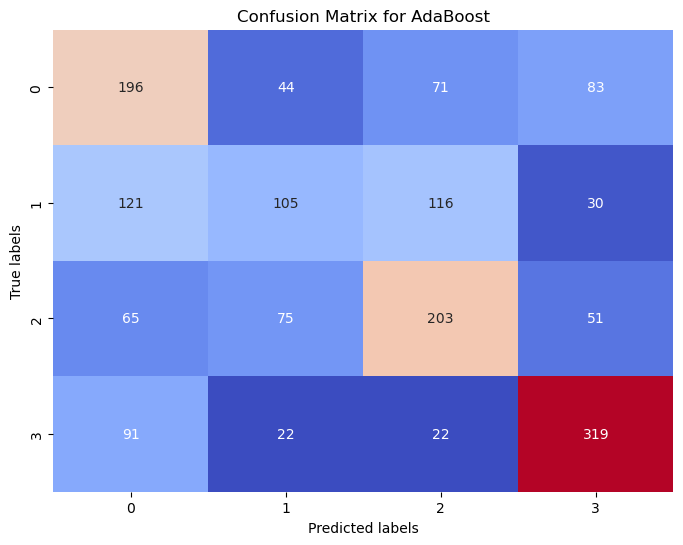

In [390]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for AdaBoost')

## SVM

In [377]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Створюємо модель SVM
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, random_state=42)

# Навчаємо модель на тренувальних даних
svm_model.fit(X_train, y_train)

# Передбачаємо цільову змінну на тестових даних
y_pred_svm = svm_model.predict(X_test)

In [379]:
# Виводимо результати
print("SVM accuracy score:", accuracy_score(y_test, y_pred_svm))
report_svm = classification_report(y_test, y_pred_svm)
print(report_svm)

SVM accuracy score: 0.5061957868649318
              precision    recall  f1-score   support

           0       0.39      0.49      0.44       394
           1       0.39      0.23      0.29       372
           2       0.53      0.53      0.53       394
           3       0.65      0.72      0.68       454

    accuracy                           0.51      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.50      0.51      0.50      1614



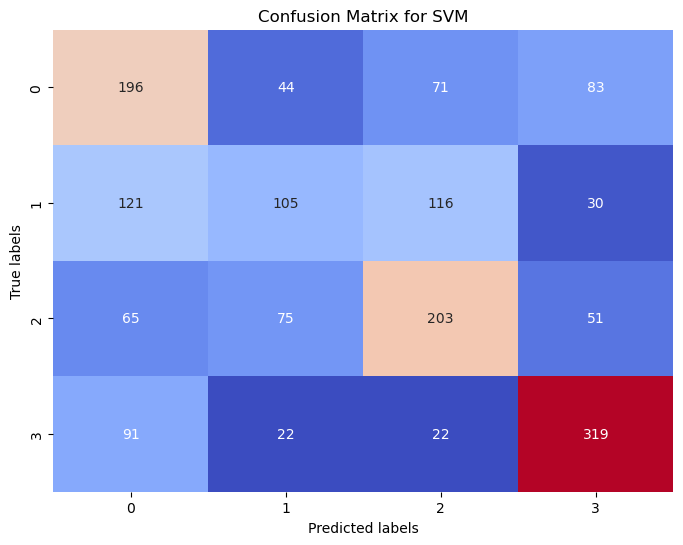

In [381]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for SVM')

In [400]:
# Визначаємо параметри для пошуку
param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}

# Створюємо модель GridSearchCV для SVM
grid_svm = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

# Найкраща модель SVM
best_svm = grid_svm.best_estimator_

# Передбачення на тестовому наборі
y_pred_svm = best_svm.predict(X_test)

In [401]:
# Виводимо результати
print("SVM (після налаштування) accuracy score:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM (після налаштування) accuracy score: 0.5061957868649318
              precision    recall  f1-score   support

           0       0.39      0.49      0.44       394
           1       0.39      0.23      0.29       372
           2       0.53      0.53      0.53       394
           3       0.65      0.72      0.68       454

    accuracy                           0.51      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.50      0.51      0.50      1614



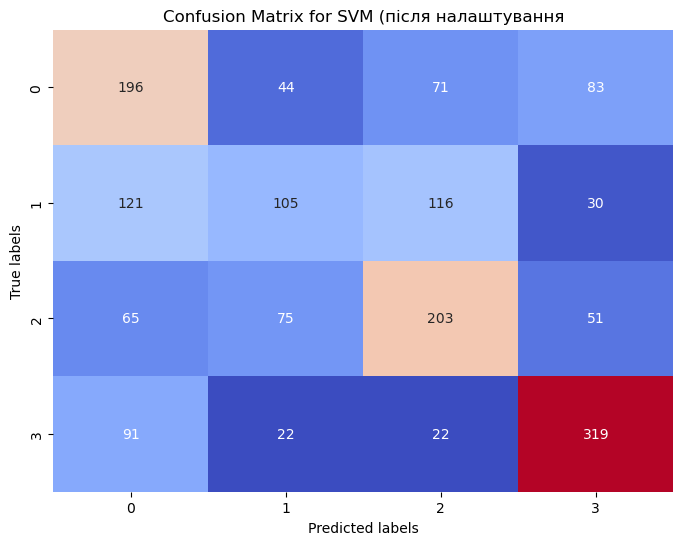

In [404]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for SVM (після налаштування')

## kNN

In [384]:
from sklearn.neighbors import KNeighborsClassifier

# Створюємо модель kNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Навчаємо модель на тренувальних даних
knn_model.fit(X_train, y_train)

# Передбачаємо цільову змінну на тестових даних
y_pred_knn = knn_model.predict(X_test)

In [386]:
# Виводимо результати
print("kNN accuracy score:", accuracy_score(y_test, y_pred_knn))
report_knn = classification_report(y_test, y_pred_knn)
print(report_knn)

kNN accuracy score: 0.459727385377943
              precision    recall  f1-score   support

           0       0.36      0.46      0.40       394
           1       0.34      0.30      0.32       372
           2       0.50      0.47      0.49       394
           3       0.65      0.57      0.61       454

    accuracy                           0.46      1614
   macro avg       0.46      0.45      0.46      1614
weighted avg       0.47      0.46      0.46      1614



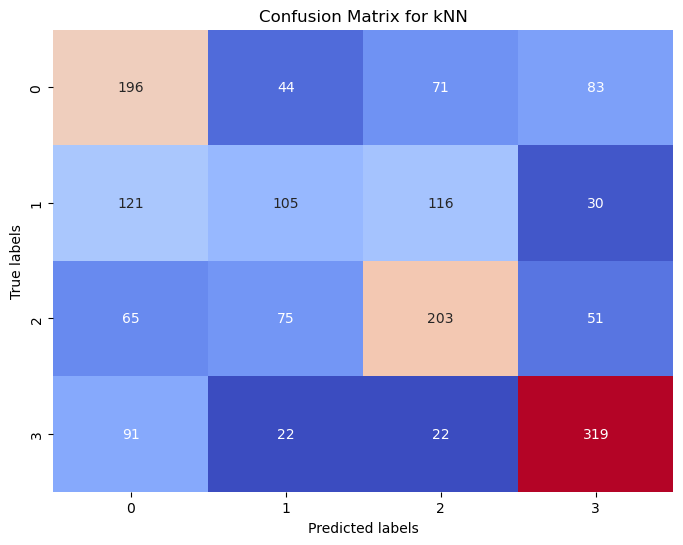

In [388]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for kNN')

In [392]:
from sklearn.model_selection import GridSearchCV

# Визначаємо параметри для пошуку
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

# Створюємо модель GridSearchCV для kNN
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)

# Найкраща модель kNN
best_knn = grid_knn.best_estimator_

# Передбачення на тестовому наборі
y_pred_knn = best_knn.predict(X_test)

In [396]:
# Виводимо результати
print("kNN (після налаштування) accuracy score:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

kNN (після налаштування) accuracy score: 0.4758364312267658
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       394
           1       0.35      0.27      0.30       372
           2       0.50      0.54      0.52       394
           3       0.64      0.63      0.64       454

    accuracy                           0.48      1614
   macro avg       0.46      0.47      0.46      1614
weighted avg       0.47      0.48      0.47      1614



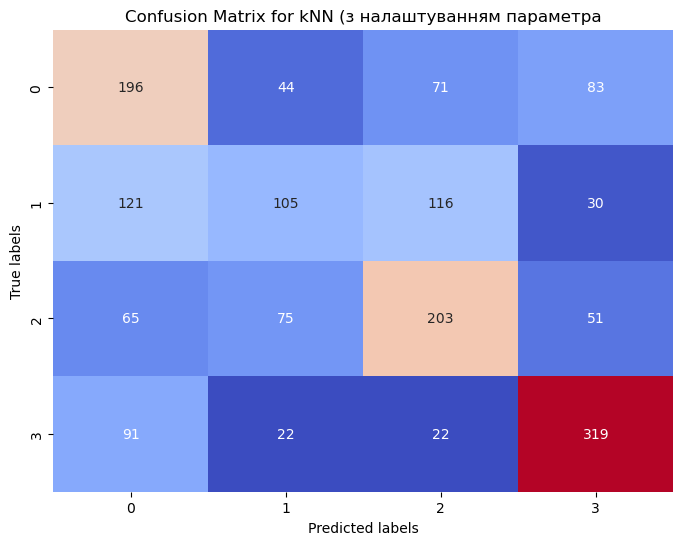

In [398]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for kNN (з налаштуванням параметра')

## **6. Results**

In [407]:
results = pd.DataFrame({'Algorithm': ['Desicion Tree', 'Random Forest', 'AdaBoost', 'KNN', 'SVM'], 'Score': [0.477, 0.508, 0.510, 0.476, 0.506]})

results

,Algorithm,Score
0,Desicion Tree,0.477
1,Random Forest,0.508
2,AdaBoost,0.510
3,KNN,0.476
4,SVM,0.506


In [ ]:
Можемо зробити висновок, що найкраще класифікує цей датасет Ad